<a href="https://colab.research.google.com/github/ibmm-unibe-ch/Heavy2Light/blob/main/Run_Heavy2Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heavy2Light

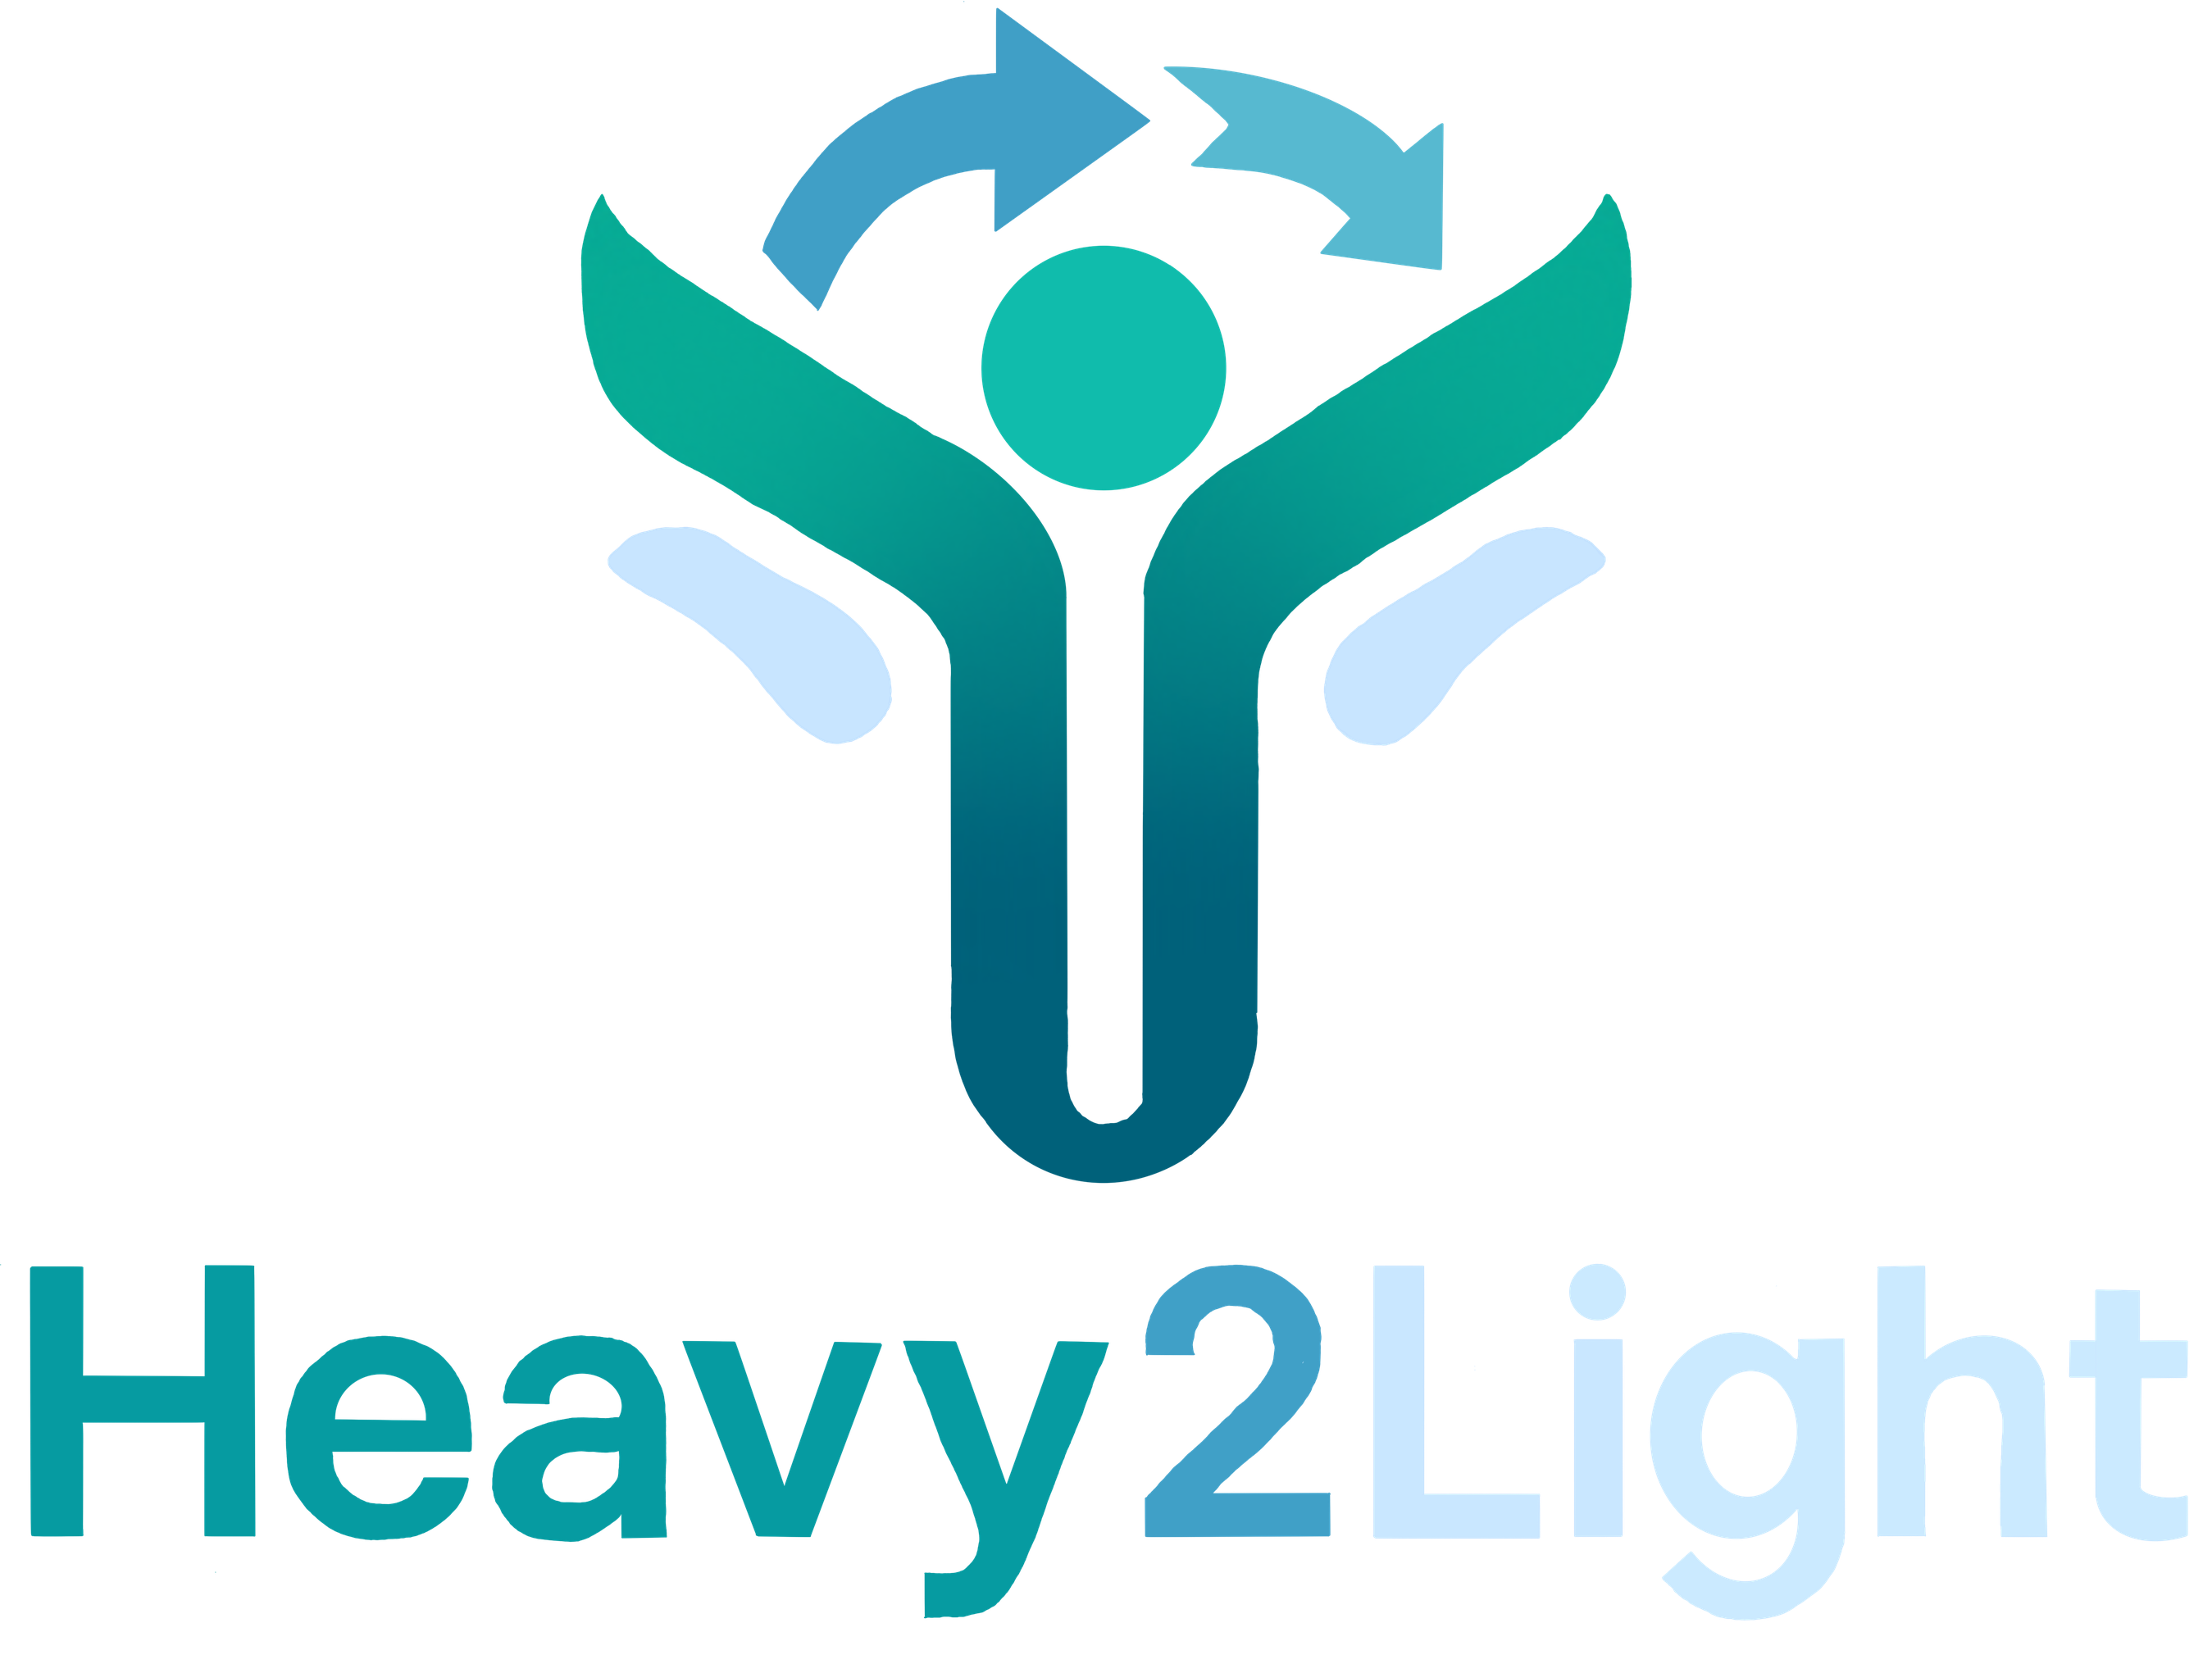

Heavy2Light is a deep learning model for heavy-to-light antibody sequence translation.  
## How to access
You can directly access the model checkpoint and the adapter on [Huggingface](https://huggingface.co/leaBroe/Heavy2Light)   
This notebook serves as a practical starting point for working with the model. It enables you to:  
	1.	Generate a light antibody chain based on a given heavy chain.  
	2.	Input a CSV, TXT, or FASTA file containing multiple heavy chains, automatically generate one or more corresponding light chains for each, and export the results as a CSV file.

In [1]:
%%capture
#@title Import dependencies
! pip install adapters

import pandas as pd
import numpy as np
from transformers import EncoderDecoderModel, AutoTokenizer, GenerationConfig
from adapters import init
from google.colab import files
import io
from tqdm import tqdm
import os

def detect_file_format(filename, file_content):
    """
    Automatically detect the file format based on filename and content.
    Returns: 'fasta', 'csv', or 'txt'
    """
    # First, try to detect from file extension
    file_extension = filename.lower().split('.')[-1] if '.' in filename else ''

    if file_extension in ['fa', 'fasta', 'fas']:
        return 'fasta'
    elif file_extension in ['csv']:
        return 'csv'
    elif file_extension in ['txt', 'text']:
        # Could be txt or fasta, need to check content
        pass

    # Analyze content for better detection
    lines = file_content.strip().split('\n')
    non_empty_lines = [line.strip() for line in lines if line.strip()]

    if not non_empty_lines:
        return 'txt'  # Default for empty files

    # Check for FASTA format (starts with >)
    fasta_headers = sum(1 for line in non_empty_lines if line.startswith('>'))
    if fasta_headers > 0:
        return 'fasta'

    # Check for CSV format
    first_line = non_empty_lines[0]
    # Look for common CSV indicators
    has_commas = ',' in first_line
    has_semicolons = ';' in first_line
    has_tabs = '\t' in first_line

    # Try to detect CSV headers
    potential_csv_headers = ['id', 'name', 'sequence', 'seq', 'heavy', 'chain']
    first_line_lower = first_line.lower()
    has_csv_headers = any(header in first_line_lower for header in potential_csv_headers)

    if (has_commas or has_semicolons or has_tabs) and (has_csv_headers or len(non_empty_lines) > 1):
        # Additional check: try to parse as CSV
        try:
            import csv
            from io import StringIO
            # Try different delimiters
            for delimiter in [',', ';', '\t']:
                if delimiter in first_line:
                    reader = csv.reader(StringIO(file_content), delimiter=delimiter)
                    rows = list(reader)
                    if len(rows) > 1 and len(rows[0]) > 1:  # At least 2 rows and 2 columns
                        return 'csv'
        except:
            pass

    # Default to TXT format (one sequence per line)
    return 'txt'

def read_heavy_chains_from_file(file_content, file_format='txt', id_col_name='id', hc_col_name='sequence'):
    """
    Read heavy chain sequences from uploaded file.
    Supports txt, csv, and fasta formats.
    """
    heavy_chains = []

    if file_format.lower() == 'txt':
        # Assume each line is a sequence
        lines = file_content.strip().split('\n')
        for i, line in enumerate(lines):
            line = line.strip()
            if line and not line.startswith('#'):  # Skip empty lines and comments
                heavy_chains.append({
                    'id': f'heavy_chain_{i+1}',
                    'sequence': line
                })

    elif file_format.lower() == 'csv':
        # Use user-specified column names for CSV format
        try:
            # Try to detect delimiter automatically
            import csv
            sniffer = csv.Sniffer()
            delimiter = ','  # default
            try:
                delimiter = sniffer.sniff(file_content[:1024]).delimiter
            except:
                # Try common delimiters
                for d in [',', ';', '\t']:
                    if d in file_content[:500]:
                        delimiter = d
                        break

            df = pd.read_csv(io.StringIO(file_content), delimiter=delimiter)
            print(f"CSV detected with delimiter '{delimiter}' and columns: {list(df.columns)}")

            # Check if specified columns exist
            if hc_col_name not in df.columns:
                print(f"Warning: Column '{hc_col_name}' not found in CSV.")
                # Try to find sequence column automatically
                seq_col = None
                for col in ['sequence', 'seq', 'heavy_chain', 'heavy_sequence', 'heavy', 'hc']:
                    if col.lower() in [c.lower() for c in df.columns]:
                        seq_col = next(c for c in df.columns if c.lower() == col.lower())
                        break
                if seq_col is None:
                    seq_col = df.columns[0]
                    print(f"Using first column '{seq_col}' as sequence column")
                else:
                    print(f"Auto-detected sequence column: '{seq_col}'")
                hc_col_name = seq_col
            else:
                print(f"Using sequence column: '{hc_col_name}'")

            # Check ID column
            use_id_col = id_col_name in df.columns
            if use_id_col:
                print(f"Using ID column: '{id_col_name}'")
            else:
                if id_col_name != "id":
                    print(f"Warning: Column '{id_col_name}' not found in CSV.")
                print("Using auto-generated IDs")

            for idx, row in df.iterrows():
                seq_id = row[id_col_name] if use_id_col else f'heavy_chain_{idx+1}'
                heavy_chains.append({
                    'id': str(seq_id),
                    'sequence': str(row[hc_col_name]).strip()
                })

        except Exception as e:
            print(f"Error parsing CSV file: {e}")
            print("Attempting to parse as TXT format instead...")
            # Fallback to TXT format
            lines = file_content.strip().split('\n')
            for i, line in enumerate(lines):
                line = line.strip()
                if line and not line.startswith('#'):
                    heavy_chains.append({
                        'id': f'heavy_chain_{i+1}',
                        'sequence': line
                    })

    elif file_format.lower() == 'fasta':
        # Parse FASTA format
        lines = file_content.strip().split('\n')
        current_id = None
        current_seq = []

        for line in lines:
            line = line.strip()
            if line.startswith('>'):
                # Save previous sequence if exists
                if current_id and current_seq:
                    heavy_chains.append({
                        'id': current_id,
                        'sequence': ''.join(current_seq)
                    })
                # Start new sequence
                current_id = line[1:].strip() or f'heavy_chain_{len(heavy_chains)+1}'
                current_seq = []
            elif line:
                current_seq.append(line)

        # Don't forget the last sequence
        if current_id and current_seq:
            heavy_chains.append({
                'id': current_id,
                'sequence': ''.join(current_seq)
            })

    return heavy_chains

def generate_light_chains(heavy_chain_seq, num_sequences=1, temperature=1.0):
    """
    Generate light chain sequences for a given heavy chain.
    """
    inputs = tokenizer(
        heavy_chain_seq,
        padding="max_length",
        truncation=True,
        max_length=250,
        return_tensors="pt"
    )

    generated_seq = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        num_return_sequences=num_sequences,
        output_scores=True,
        return_dict_in_generate=True,
        generation_config=generation_config,
        bad_words_ids=[[4]],
        do_sample=True,
        temperature=temperature,
    )

    light_chains = []
    for seq in generated_seq.sequences:
        generated_text = tokenizer.decode(seq, skip_special_tokens=True)
        light_chains.append(generated_text)

    return light_chains

def process_batch(heavy_chains, num_light_chains_per_heavy=1, temperature=1.0):
    """
    Process a batch of heavy chains and generate light chains for each.
    """
    results = []

    print(f"Processing {len(heavy_chains)} heavy chain sequences...")
    print(f"Generating {num_light_chains_per_heavy} light chain(s) per heavy chain")

    for heavy_chain in tqdm(heavy_chains, desc="Generating light chains"):
        heavy_id = heavy_chain['id']
        heavy_seq = heavy_chain['sequence']

        try:
            light_chains = generate_light_chains(
                heavy_seq,
                num_sequences=num_light_chains_per_heavy,
                temperature=temperature
            )

            for i, light_seq in enumerate(light_chains):
                results.append({
                    'heavy_chain_id': heavy_id,
                    'heavy_chain_sequence': heavy_seq,
                    'light_chain_id': f"{heavy_id}_light_{i+1}",
                    'light_chain_sequence': light_seq,
                    'generation_temperature': temperature
                })

        except Exception as e:
            print(f"Error processing {heavy_id}: {str(e)}")
            # Add error entry
            results.append({
                'heavy_chain_id': heavy_id,
                'heavy_chain_sequence': heavy_seq,
                'light_chain_id': f"{heavy_id}_error",
                'light_chain_sequence': f"ERROR: {str(e)}",
                'generation_temperature': temperature
            })

    return results

In [2]:
#@title Load and initialize Heavy2Light from Huggingface
from transformers import EncoderDecoderModel, AutoTokenizer, GenerationConfig, set_seed
from adapters import init

model_path = "leaBroe/Heavy2Light"
subfolder_path = "heavy2light_final_checkpoint"


model = EncoderDecoderModel.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path, subfolder=subfolder_path)

init(model)
adapter_name = model.load_adapter("leaBroe/Heavy2Light_adapter", set_active=True)
print("Loaded adapter:", adapter_name)
model.set_active_adapters("heavy2light_adapter")

generation_config = GenerationConfig.from_pretrained(model_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded adapter: heavy2light_adapter


In [3]:
#@title Run Heavy2Light on a single heavy chain input
# @markdown #### Input Heavy Sequence
heavy_seq='QLQVQESGPGLVKPSETLSLTCTVSGASSSIKKYYWGWIRQSPGKGLEWIGSIYSSGSTQYNPALGSRVTLSVDTSQTQFSLRLTSVTAADTATYFCARQGADCTDGSCYLNDAFDVWGRGTVVTVSS' # @param {type:"string"}

set_seed(42)

inputs = tokenizer(
    heavy_seq,
    padding="max_length",
    truncation=True,
    max_length=250,
    return_tensors="pt"
)

generated_seq = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    num_return_sequences=1,
    output_scores=True,
    return_dict_in_generate=True,
    generation_config=generation_config,
    bad_words_ids=[[4]],
    do_sample=True,
    temperature=1.0
)

generated_text = tokenizer.decode(
    generated_seq.sequences[0],
    skip_special_tokens=True,
)

print("Generated light sequence:", generated_text)

Generated light sequence: SYDLTQPPSVSVSPGQTASITCSGDRLGDKYTSWYQQKAGQSPVLVIYQDDKRPSGIPDRFSGSNSGNTATLTISGTQPMDEADYYCQAWDSRTVIFGGGTKLTVL


### The input files should be of the following format:  
.txt: one heavy chain sequence per line, no IDs (IDs will be automatically generated ("heavy_chain_x")  
.csv: one column should be the ID of the heavy chain, and another the sequence. If there is no ID column provided, IDs are generated automatically.  
.fasta: standard fasta format

In [4]:
#@title Run Heavy2Light on multiple heavy chains
# @markdown #### Processing Mode
process_multiple_seqs = True # @param {type:"boolean"}

# @markdown #### Generation Parameters
num_light_chains_per_heavy = 1 # @param {type:"integer"}
temperature = 0.8 # @param {type:"number"}

# @markdown #### Batch Processing Options
output_filename = "generated_light_chains.csv" # @param {type:"string"}

# @markdown #### CSV Format Options
id_col_name = "id" # @param {type:"string"}
hc_col_name = "sequence" # @param {type:"string"}

In [5]:
#@title Run Heavy2Light over multiple sequences

print("\n" + "="*60)
if process_multiple_seqs:
    print("PROCESSING MULTIPLE SEQUENCES")
    print("="*60)

    print(f"Light chains per heavy chain: {num_light_chains_per_heavy}")
    print(f"Generation temperature: {temperature}")
    print(f"Output filename: {output_filename}")

    print("\nSupported file formats:")
    print("- TXT: One sequence per line")
    print("- CSV: With specified column names")
    print("- FASTA: Standard FASTA format")

    print(f"\nPlease upload your file with heavy chain sequences:")
    uploaded = files.upload()

    if uploaded:
        # Get the uploaded file
        filename = list(uploaded.keys())[0]
        file_content = uploaded[filename].decode('utf-8')

        detected_format = detect_file_format(filename, file_content)


        # Parse the file
        heavy_chains = read_heavy_chains_from_file(file_content, detected_format, hc_col_name, id_col_name)
        print(f"\nFound {len(heavy_chains)} heavy chain sequences")

        # Display first few sequences for verification
        print("\nFirst few sequences:")
        for i, hc in enumerate(heavy_chains[:3]):
            print(f"{i+1}. ID: {hc['id']}")
            print(f"   Sequence: {hc['sequence'][:50]}{'...' if len(hc['sequence']) > 50 else ''}")

        if len(heavy_chains) > 3:
            print(f"... and {len(heavy_chains) - 3} more sequences")

        # Process the batch
        results = process_batch(
            heavy_chains,
            num_light_chains_per_heavy=num_light_chains_per_heavy,
            temperature=temperature
        )

        # Create DataFrame and save to CSV
        df_results = pd.DataFrame(results)

        # Save to CSV
        df_results.to_csv(output_filename, index=False)

        print(f"\n" + "="*60)
        print("RESULTS SUMMARY")
        print("="*60)
        print(f"Total heavy chains processed: {len(heavy_chains)}")
        print(f"Total light chains generated: {len(df_results)}")
        print(f"Light chains per heavy chain: {num_light_chains_per_heavy}")
        print(f"Generation temperature: {temperature}")
        print(f"Results saved to: {output_filename}")

        # Display sample results
        print(f"\nSample results:")
        print(df_results.head())

        # Download the results file
        print(f"\nDownloading results file...")
        files.download(output_filename)

    else:
        print("No file uploaded. Please run the cell again and upload a file.")

else:
    print("SINGLE SEQUENCE MODE DISABLED")
    print("="*60)
    print("Please enable 'process_multiple_seqs' to use batch processing mode.")
    print("For single sequence processing, set process_multiple_seqs = True")
    print("and upload a file with a single sequence.")

print("\n" + "="*60)
print("DONE!")
print("="*60)


PROCESSING MULTIPLE SEQUENCES
Light chains per heavy chain: 1
Generation temperature: 0.8
Output filename: generated_light_chains.csv

Supported file formats:
- TXT: One sequence per line
- CSV: With specified column names
- FASTA: Standard FASTA format

Please upload your file with heavy chain sequences:


Saving small_example_hc.txt to small_example_hc.txt

Found 4 heavy chain sequences

First few sequences:
1. ID: heavy_chain_1
   Sequence: QVQLQESGPGLVKPSETLSLTCTVSGGSISGFYWSWIRQSPGKGLEWIAY...
2. ID: heavy_chain_2
   Sequence: QVQLQESGPGLVKPSETLSLICNVTGFSISGYFWSWVRQPPGKGLEWIAS...
3. ID: heavy_chain_3
   Sequence: QVQLQESGPGLVKPSETLSLTCTVSGGSISSYHWSWIRQPPGKGLEWIGY...
... and 1 more sequences
Processing 4 heavy chain sequences...
Generating 1 light chain(s) per heavy chain


Generating light chains: 100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


RESULTS SUMMARY
Total heavy chains processed: 4
Total light chains generated: 4
Light chains per heavy chain: 1
Generation temperature: 0.8
Results saved to: generated_light_chains.csv

Sample results:
  heavy_chain_id                               heavy_chain_sequence  \
0  heavy_chain_1  QVQLQESGPGLVKPSETLSLTCTVSGGSISGFYWSWIRQSPGKGLE...   
1  heavy_chain_2  QVQLQESGPGLVKPSETLSLICNVTGFSISGYFWSWVRQPPGKGLE...   
2  heavy_chain_3  QVQLQESGPGLVKPSETLSLTCTVSGGSISSYHWSWIRQPPGKGLE...   
3  heavy_chain_4  QVQLQESGPGLVKPSETLSLTCNVSGYSISSGYYWGWIRQPPGKGL...   

          light_chain_id                               light_chain_sequence  \
0  heavy_chain_1_light_1  EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...   
1  heavy_chain_2_light_1  EIVLTQSPGTLSLSPGERATLSCRASQSINRNYLAWYQQKPGQAPR...   
2  heavy_chain_3_light_1  QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAP...   
3  heavy_chain_4_light_1  QSALTQPPSASGSPGQSVTISCTGTSSDVGGYNYVSWYQQHPGKAP...   

   generation_temperature  
0                

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


DONE!
